各種ライブラリのインポート

In [ ]:
!pip install numpy==1.25.0 #NumPyが最新だと1.26.1だが、他の関連するライブラリの対応範囲を超えており、互換性の問題を回避するため、いったん今回はあえてダウングレードする。また、runtimeのrestartが必要になる。

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 49.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
!pip install lingam
!pip install factor_analyzer
!pip install igraph
!pip install pygam
!pip install causal-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.7 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=190d8a81005f3949cf116f408c4b8d53e5327e2188cac383e71e169c5f3efa2b
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=46b2a82fb329018cee261519df1ae26d42

In [ ]:
import sys

import numpy as np
import pandas as pd
import graphviz
import sklearn
import warnings
import os
import matplotlib.pyplot as plt
import copy

from lingam.utils import print_causal_directions, print_dagc, make_dot, make_prior_knowledge
import numbers
from sklearn.utils import check_array, resample
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search

FCIでの各種関数の定義

In [ ]:
"""
FCI's return
graph : a GeneralGraph object, where graph.graph[j,i]=1 and graph.graph[i,j]=-1 indicates  i --> j ,
                                     graph.graph[i,j] = graph.graph[j,i] = -1 indicates i --- j,
                                     graph.graph[i,j] = graph.graph[j,i] = 1 indicates i <-> j,
                                     graph.graph[j,i]=1 and graph.graph[i,j]=2 indicates  i o-> j.
"""

class BootstrapMixin:
    """Mixin class for all FCI algorithms that implement the method of bootstrapping."""

    def bootstrap(self, X_original, n_sampling, labels, i_type, background_knowledge):
        """Evaluate the statistical reliability of DAG based on the bootstrapping.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.
        n_sampling : int
            Number of bootstrapping samples.

        Returns
        -------
        result : BootstrapResult
            Returns the result of bootstrapping.
        """
        # Check parameters
        X_original = check_array(X_original)

        if isinstance(n_sampling, (numbers.Integral, np.integer)):
            if not 0 < n_sampling:
                raise ValueError("n_sampling must be an integer greater than 0.")
        else:
            raise ValueError("n_sampling must be an integer greater than 0.")

        # Bootstrapping
        self.graph_matrices = np.zeros([n_sampling, X_original.shape[1], X_original.shape[1]])

        self.n_features = X_original.shape[1]
        self.labels = labels
        #self.labels = ['x'+str(i_nf) for i_nf in range (self.n_features)]
        for i in range(n_sampling):
            resampled_X = resample(X_original)
            G_temp, _ = fci(resampled_X, independence_test_method="fisherz", background_knowledge=background_knowledge, show_progress=False)
            self.graph_matrices[i,:,:] = G_temp.graph
            #print(G_temp.graph)
            """
            if i <= 2:
                pdy = GraphUtils.to_pydot(G_temp, labels=labels)
                if i_type == 0:
                    pdy.write_png('Doctor_fci_type1_' + str(i) + '_th_BStry.png')
                elif i_type == 1:
                    pdy.write_png('Doctor_fci_type2_' + str(i) + '_th_BStry.png')
                elif i_type == 2:
                    pdy.write_png('Doctor_fci_type3_' + str(i) + '_th_BStry.png')
            """
        return self.graph_matrices

    def get_probabilities(self, threshold):
        """Get bootstrap probability.
        threshold : float
            Threshold for detecting causal direction.
            Causal directions with bootstrap probability less than
            ``threshold`` are excluded.

        Returns
        -------
        probabilities : array-like
            List of bootstrap probability matrix.
        """
        adjacency_matrices = np.nan_to_num(self.graph_matrices)
        shape = adjacency_matrices[0].shape
        bp = np.zeros(shape)

        adjacency_matrices_tail = np.where( adjacency_matrices ==-1, 1, 0)
        adjacency_matrices_head = np.where( adjacency_matrices == 1, 1, 0)
        adjacency_matrices_ambi = np.where( adjacency_matrices == 2, 1, 0)

        adjacency_matrices_tail_head = adjacency_matrices_tail*adjacency_matrices_head.transpose(0,2,1)
        adjacency_matrices_head_tail = adjacency_matrices_head*adjacency_matrices_tail.transpose(0,2,1)
        adjacency_matrices_head_head = adjacency_matrices_head*adjacency_matrices_head.transpose(0,2,1)
        adjacency_matrices_head_ambi = adjacency_matrices_head*adjacency_matrices_ambi.transpose(0,2,1)
        adjacency_matrices_ambi_head = adjacency_matrices_ambi*adjacency_matrices_head.transpose(0,2,1)
        adjacency_matrices_ambi_ambi = adjacency_matrices_ambi*adjacency_matrices_ambi.transpose(0,2,1)

        bp_tail_head = np.triu( np.mean(adjacency_matrices_tail_head, axis=0) )
        bp_head_tail = np.triu( np.mean(adjacency_matrices_head_tail, axis=0) )
        bp_head_head = np.triu( np.mean(adjacency_matrices_head_head, axis=0) )
        bp_head_ambi = np.triu( np.mean(adjacency_matrices_head_ambi, axis=0) )
        bp_ambi_head = np.triu( np.mean(adjacency_matrices_ambi_head, axis=0) )
        bp_ambi_ambi = np.triu( np.mean(adjacency_matrices_ambi_ambi, axis=0) )

        bp_tail_head = np.where(bp_tail_head >= threshold, bp_tail_head, 0.0)
        bp_head_tail = np.where(bp_head_tail >= threshold, bp_head_tail, 0.0)
        bp_head_head = np.where(bp_head_head >= threshold, bp_head_head, 0.0)
        bp_head_ambi = np.where(bp_head_ambi >= threshold, bp_head_ambi, 0.0)
        bp_ambi_head = np.where(bp_ambi_head >= threshold, bp_ambi_head, 0.0)
        bp_ambi_ambi = np.where(bp_ambi_ambi >= threshold, bp_ambi_ambi, 0.0)

        self.bp = np.array([bp_tail_head,bp_head_tail,bp_head_head,bp_head_ambi,bp_ambi_head,bp_ambi_ambi])
        return copy.deepcopy(self.bp)

    def arrow(self, index0):
        if index0 == 0:
           return ' --> ', 'none', 'normal'
        elif index0 == 1:
           return ' <-- ', 'normal', 'none'
        elif index0 == 2:
           return ' <-> ', 'normal', 'normal'
        elif index0 == 3:
           return ' <-o ', 'normal', 'odot'
        elif index0 == 4:
           return ' o-> ', 'odot', 'normal'
        elif index0 == 5:
           return ' o-o ', 'odot', 'odot'

    def print_probabilities(self, filename):
        #print(self.bp)
        dot = graphviz.Digraph(format = 'png', comment = "")
        for i_nf in range (self.n_features):
           dot.node(str(i_nf), self.labels[i_nf])

        indices = np.argsort(self.bp, axis=None)[::-1]
        index_to_index_proto = np.arange(self.bp.size)
        index_to_index_0 = index_to_index_proto//(self.bp.shape[1]*self.bp.shape[2])
        index_to_index_1 = (index_to_index_proto%(self.bp.shape[1]*self.bp.shape[2]))//self.bp.shape[2]
        index_to_index_2 = index_to_index_proto%self.bp.shape[2]
        for id in indices:
            prob = self.bp[index_to_index_0[id]][index_to_index_1[id]][index_to_index_2[id]]
            arrow, tail_temp, head_temp = self.arrow(index_to_index_0[id])
            dot.edge(str(index_to_index_1[id]), str(index_to_index_2[id]), label=str(prob), dir='both', arrowhead=head_temp, arrowtail=tail_temp )
            if prob > 0.0:
               print( str(self.labels[index_to_index_1[id]]) + arrow + str(self.labels[index_to_index_2[id]]) + '	(' + str(prob) + ')' )
            else:
               break
        dot.render('./' + filename, view=True)

def convert_adj_matrix_to_bk(adj_matrix, data, nodes_0):

    #data_array = data.to_numpy()
    #cg_without_background_knowledge = pc(data_array, independence_test_method="fisherz")  # Run PC and obtain the estimated graph (CausalGraph object)
    #nodes = cg_without_background_knowledge.G.get_nodes()
    bk_0 = BackgroundKnowledge()
    num_nodes = adj_matrix.shape[0]

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i, j] == 1:
                # j -> i required
                bk_0.add_required_by_node(nodes_0[j], nodes_0[i])
            elif adj_matrix[i, j] == 0:
                #  j -> i forbidden
                bk_0.add_forbidden_by_node(nodes_0[j], nodes_0[i])

    return bk_0

In [ ]:
 #基礎設定
 # 再現性のためにランダムシードを固定する
np.random.seed(103)
 # 時定数としてどこまで採用するか
tau_max = 1
take_log = True
log_cutoff_for_zeros = -5

In [ ]:
#データセットを読み込む
X0 = pd.read_csv('/content/250907_3type_lag1.csv', index_col=None)

#重点支援3類型でデータを分ける
X = [None for _ in range(3)]
for i_type in range(3):
    X[i_type] = X0[X0['support_type']==i_type+1]
    X[i_type] = X[i_type].drop(['FY', 'support_type'], axis=1)
    if take_log:
        X[i_type] = np.log10( np.maximum(X[i_type],10**log_cutoff_for_zeros) )
    x_list = X[0].columns.tolist()
    n_features = X[0].shape[1]//(tau_max+1)

In [ ]:
# 重点支援1
X[0]

,M_graduate,D_entrance,Ph.D_Graduate,PosDoc,AcaPos,Basic_income,Students_per_teacher,DC1,M_graduate_L1,D_entrance_L1,Ph.D_graduate_L1,PosDoc_L1,AcaPos_L1,Basic_income_L1,Students_per_teacher_L1,DC1_L1
1,2.096910,0.602060,-5.000000,-5.000000,-5.000000,6.789847,1.176091,-5.00000,2.025306,0.477121,-5.000000,-5.000000,-5.000000,6.779954,1.158362,-5.0
2,2.444045,0.698970,1.278754,0.301030,0.602060,6.411047,1.252853,-5.00000,2.332438,0.778151,1.079181,0.477121,0.301030,6.414452,1.230449,-5.0
3,1.079181,0.301030,0.477121,0.301030,-5.000000,6.090853,1.278754,-5.00000,1.041393,0.301030,0.000000,-5.000000,-5.000000,6.094054,1.264818,-5.0
4,1.986772,1.113943,1.079181,-5.000000,-5.000000,6.378898,1.025306,-5.00000,1.913814,1.146128,1.000000,0.698970,-5.000000,6.357790,1.008600,-5.0
5,2.068186,0.301030,1.000000,0.000000,0.477121,6.327193,1.167317,-5.00000,2.096910,0.301030,1.146128,-5.000000,-5.000000,6.357311,1.143015,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,2.875640,1.698970,2.143015,1.041393,1.278754,7.142538,1.071882,0.90309,2.865104,1.755875,2.167317,1.230449,1.230449,7.140536,1.071882,0.0
855,2.496930,0.301030,1.505150,-5.000000,0.477121,6.942965,0.939519,-5.00000,2.487138,0.845098,1.301030,-5.000000,0.698970,6.948042,0.929419,-5.0
856,2.557507,1.113943,1.732394,-5.000000,1.113943,6.967220,0.869232,0.30103,2.530200,1.322219,1.770852,0.000000,1.079181,6.962534,0.886491,-5.0
857,2.763428,1.176091,2.033424,1.079181,1.397940,7.184700,0.963788,0.30103,2.767156,1.431364,1.934498,0.602060,1.079181,7.177978,0.968483,-5.0


In [ ]:
#重点支援2
X[1]

,M_graduate,D_entrance,Ph.D_Graduate,PosDoc,AcaPos,Basic_income,Students_per_teacher,DC1,M_graduate_L1,D_entrance_L1,Ph.D_graduate_L1,PosDoc_L1,AcaPos_L1,Basic_income_L1,Students_per_teacher_L1,DC1_L1
16,0.778151,-5.000000,-5.000000,-5.000000,-5.000000,6.360874,0.518514,-5.00000,0.602060,-5.000000,-5.000000,-5.000000,-5.000000,6.353734,0.531479,-5.000000
22,2.459392,1.414973,2.376577,0.845098,1.041393,7.136003,0.579784,0.30103,2.465383,1.462398,2.383815,1.230449,1.041393,7.149639,0.579784,0.301030
23,2.071882,1.431364,1.278754,0.698970,0.301030,6.469699,1.243038,0.00000,2.107210,1.518514,1.568202,0.778151,0.000000,6.447989,1.250420,0.000000
24,2.600973,1.690196,1.724276,1.397940,0.477121,6.649843,1.143015,0.00000,2.588832,1.591065,1.681241,1.113943,0.301030,6.636892,1.149219,0.000000
26,2.359835,1.633468,1.944483,0.477121,1.146128,6.641919,1.139879,-5.00000,2.429752,1.778151,1.949390,1.785330,1.000000,6.630718,1.139879,0.301030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,2.496930,1.748188,1.770852,1.301030,0.000000,6.726582,0.857332,-5.00000,2.440909,1.707570,1.785330,1.255273,0.477121,6.730034,0.845098,0.000000
836,2.212188,0.954243,1.361728,0.778151,0.778151,6.549310,1.110590,-5.00000,2.283301,1.204120,1.322219,0.602060,0.477121,6.510480,1.117271,-5.000000
837,2.530200,1.799341,1.913814,1.230449,1.176091,6.719010,0.672098,0.00000,2.521138,1.792392,1.991226,1.380211,1.079181,6.763116,0.672098,0.477121
849,2.770115,1.322219,1.880814,0.477121,0.903090,6.697909,1.201397,-5.00000,2.768638,1.397940,1.857332,1.079181,0.903090,6.739084,1.193125,0.301030


In [ ]:
#重点支援3
X[2]

,M_graduate,D_entrance,Ph.D_Graduate,PosDoc,AcaPos,Basic_income,Students_per_teacher,DC1,M_graduate_L1,D_entrance_L1,Ph.D_graduate_L1,PosDoc_L1,AcaPos_L1,Basic_income_L1,Students_per_teacher_L1,DC1_L1
0,3.250664,2.421604,2.684845,1.968483,1.770852,7.525837,0.875061,1.431364,3.264346,2.403121,2.746634,1.875061,1.724276,7.528657,0.863323,1.623249
9,3.308991,2.555094,2.817565,2.021189,1.908485,7.629442,0.778151,1.653213,3.301464,2.507856,2.800029,2.071882,1.934498,7.622948,0.755875,1.707570
15,3.260310,2.372912,2.603144,2.008600,1.690196,7.556772,0.959041,1.477121,3.268578,2.385606,2.570543,2.021189,1.531479,7.552465,0.954243,1.491362
20,3.063333,2.049218,2.439333,1.505150,1.672098,7.210687,1.082785,0.477121,3.058805,2.004321,2.445604,1.361728,1.505150,7.197216,1.082785,1.000000
21,3.500099,2.899273,3.221153,1.929419,2.146128,7.879628,0.857332,2.305351,3.490661,2.937016,3.213252,2.021189,2.089905,7.868754,0.857332,2.334454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,3.344785,2.506505,2.874482,2.071882,1.892095,7.652195,0.832509,1.681241,3.369587,2.550228,2.872739,2.029384,1.826075,7.642504,0.838849,1.672098
833,3.107888,2.064458,2.480007,1.176091,1.602060,7.305734,1.012837,1.000000,3.118265,2.060698,2.498311,1.204120,1.716003,7.310419,1.008600,0.845098
841,2.940516,1.681241,2.365488,1.301030,1.380211,7.257619,0.959041,0.301030,2.985426,1.819544,2.418301,1.518514,1.477121,7.270115,0.949390,0.301030
842,3.155640,2.235528,2.584331,1.079181,1.968483,7.397122,0.897627,0.954243,3.138934,2.143015,2.593286,1.740363,1.913814,7.402758,0.913814,0.602060


In [ ]:
# FCIではNumpy arrayにしておく。
X_np_array = [None for _ in range(3)]
X_np_array[0] =  X[0].to_numpy()
X_np_array[1] =  X[1].to_numpy()
X_np_array[2] =  X[2].to_numpy()

FCIの準備

事前知識の準備

In [ ]:
prior_knowledge = np.loadtxt('/content/250907_prior_knowledge_lag1.csv', delimiter=',',dtype ='int64')
prior_knowledge

array([[-1,  0, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [ ]:
#prior_knowledge = -np.ones((X[0].shape[1],X[0].shape[1])).astype(int)
#prior_knowledge_contemporary = np.array(
#    [[-1,  0, -1, -1, -1, -1, -1, -1],
#     [-1, -1, -1, -1, -1, -1, -1, -1],
#     [-1, -1, -1,  0,  0, -1, -1, -1],
#     [-1, -1, -1, -1, -1, -1, -1, -1],
#     [-1, -1, -1, -1, -1, -1, -1, -1],
#     [-1, -1, -1, -1, -1, -1, -1, -1],
#     [-1, -1, -1, -1, -1, -1, -1, -1],
#     [ 0,  0,  0,  0,  0,  0,  0, -1]]
#    )

#for t in range (tau_max+1):
#        prior_knowledge[t*n_features:(t+1)*n_features,t*n_features:(t+1)*n_features] = prior_knowledge_contemporary
#        for t_L in range(t+1,tau_max+1):
#            prior_knowledge[t*n_features:(t+1)*n_features,t_L*n_features:(t_L+1)*n_features] = 0

df_array = X[0].to_numpy()
cg_without_background_knowledge = pc(df_array, independence_test_method="fisherz")  # Run PC and obtain the estimated graph (CausalGraph object)
nodes = cg_without_background_knowledge.G.get_nodes()
bk = convert_adj_matrix_to_bk(prior_knowledge, df_array, nodes)

  0%|          | 0/16 [00:00<?, ?it/s]

ラベルの準備

In [ ]:
x_list = ['M graduate(X0)', 'D entrance(X1)', 'Ph.D Graduate(X2)', 'PosDoc(X3)', 'AcaPos(X4)', 'Basic income(X5)', 'Students per teacher(X6)', 'DC1(X7)']
x_list_L1 = ['M graduate_L1(X8)', 'D entrance_L1(X9)', 'Ph.D Graduate_L1(X10)', 'PosDoc_L1(X11)', 'AcaPos_L1(X12)', 'Basic income_L1(X13)', 'Students per teacher_L1(X14)', 'DC1_L1(X15)']
x_list_whole = x_list + x_list_L1

FCIの実行（データセット全体）

In [ ]:
for i_type in range(3):
        G, edges = fci(X_np_array[i_type], independence_test_method="fisherz", background_knowledge=bk)
        print(G.graph)

        # visualization
        pdy = GraphUtils.to_pydot(G, labels=x_list_whole[:X_np_array[i_type].shape[1]])
        if i_type == 0:
            pdy.write_png('Doctor_fci_type1.png')
        elif i_type == 1:
            pdy.write_png('Doctor_fci_type2.png')
        elif i_type == 2:
            pdy.write_png('Doctor_fci_type3.png')

  0%|          | 0/16 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X1 --> X14
Orienting edge (Knowledge): X8 --> X2
Orienting edge (Knowledge): X2 --> X10
Orienting edge (Knowledge): X2 --> X15
Orienting edge (Knowledge): X3 --> X5
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X4 --> X10
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X16
Orienting edge (Knowledge): X8 --> X5
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X9
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Orienting edge (Knowledge): X8 --> X12
Orienting edge (Knowledge): X8 --> X14
Orienting edge (Knowledge): X8 --> X16
Orienting edge (Knowledge): X9 --> X10
Orienting edge (Knowledge): X11 --> X13
Orienting edge (Knowledge): X16 --> X13
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 -

  0%|          | 0/16 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X2 --> X10
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X5
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X16
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Orienting edge (Knowledge): X8 --> X16
Orienting edge (Knowledge): X11 --> X13
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X2 --> X10
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X5
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X16
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Orienting edge (Knowledge): X8 --> X16
Orienting edge (Knowledge): X11 --

  0%|          | 0/16 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X8 --> X2
Orienting edge (Knowledge): X2 --> X10
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X8 --> X2
Orienting edge (Knowledge): X2 --> X10
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Finishing BK Orientation.
X2 --> X10
X10 --> X12
[[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  

ストリーミング出力は最後の 5000 行に切り捨てられました。
Orienting edge (Knowledge): X6 --> X12
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Orienting edge (Knowledge): X8 --> X12
Orienting edge (Knowledge): X8 --> X16
Orienting edge (Knowledge): X9 --> X10
Orienting edge (Knowledge): X11 --> X13
Orienting edge (Knowledge): X16 --> X12
Orienting edge (Knowledge): X16 --> X13
Finishing BK Orientation.
X1 --> X2
X1 --> X9
X1 --> X10
X1 --> X13
X2 --> X10
X4 --> X10
X4 --> X12
X4 --> X16
X5 --> X6
X5 --> X13
X6 --> X12
X6 --> X14
X9 --> X10
X9 --> X11
X11 --> X13
X16 --> X12
X16 --> X13
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X8 --> X2
Orienting edge (Knowledge): X2 --> X10
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X5
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X16
Orienting edge (Knowledge): X8

/tmp/ipython-input-2207084634.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.savefig(figure_title)


ストリーミング出力は最後の 5000 行に切り捨てられました。
Orienting edge (Knowledge): X7 --> X15
Orienting edge (Knowledge): X8 --> X16
Orienting edge (Knowledge): X11 --> X13
Orienting edge (Knowledge): X16 --> X12
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X1 --> X10
Orienting edge (Knowledge): X2 --> X9
Orienting edge (Knowledge): X3 --> X5
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X13
Orienting edge (Knowledge): X8 --> X4
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X13
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Orienting edge (Knowledge): X8 --> X16
Orienting edge (Knowledge): X11 --> X13
Orienting edge (Knowledge): X16 --> X12
Finishing BK Orientation.
X2 --> X9
X4 --> X12
X4 --> X13
X5 --> X11
X11 --> X13
X16 --> X12
Starting BK Orientation.
Orienting edge (Know

/tmp/ipython-input-2207084634.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.savefig(figure_title)


ストリーミング出力は最後の 5000 行に切り捨てられました。
Orienting edge (Knowledge): X2 --> X10
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X9
Orienting edge (Knowledge): X6 --> X12
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Orienting edge (Knowledge): X8 --> X16
Finishing BK Orientation.
X2 --> X10
X10 --> X11
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X8 --> X2
Orienting edge (Knowledge): X2 --> X10
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X15
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X16
Orienting edge (Knowledge): X16 --> X10

/tmp/ipython-input-2207084634.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.savefig(figure_title)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


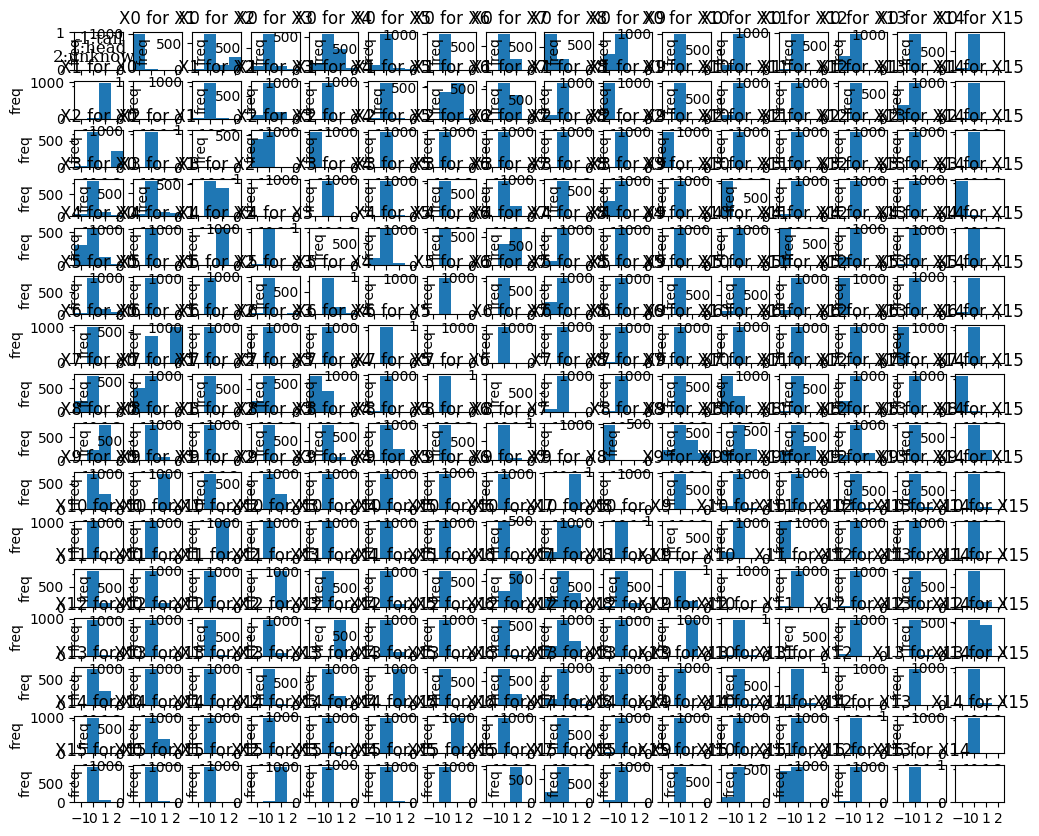

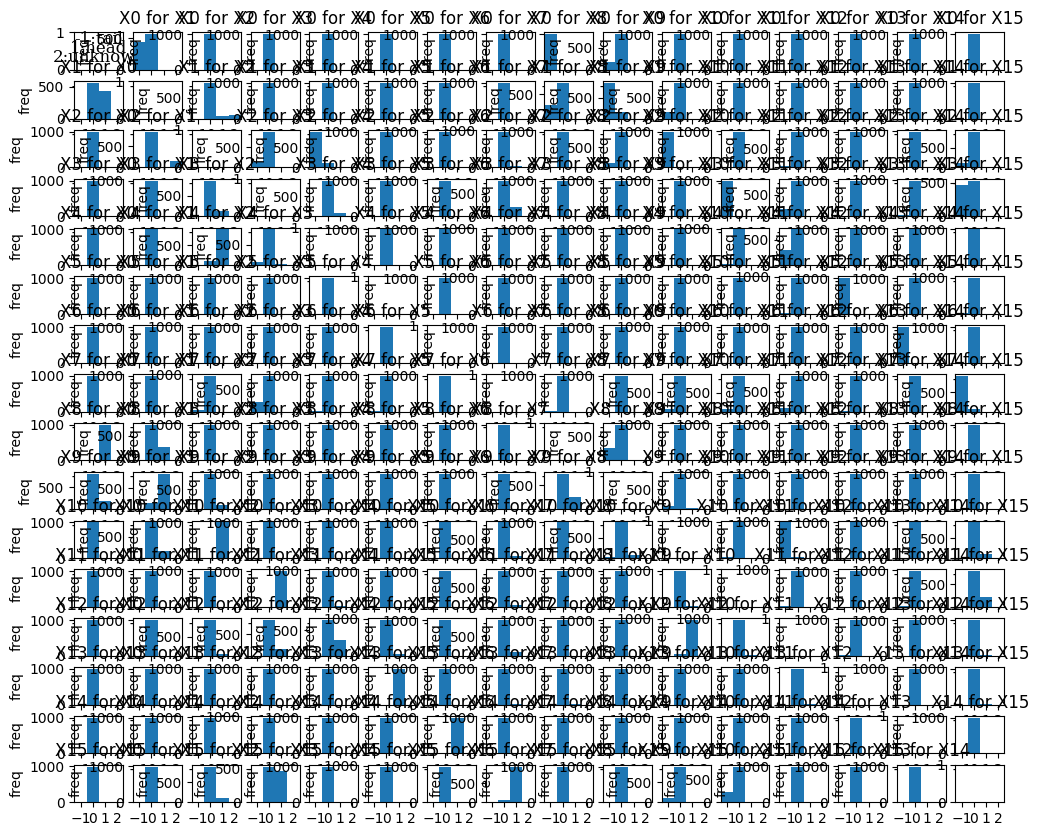

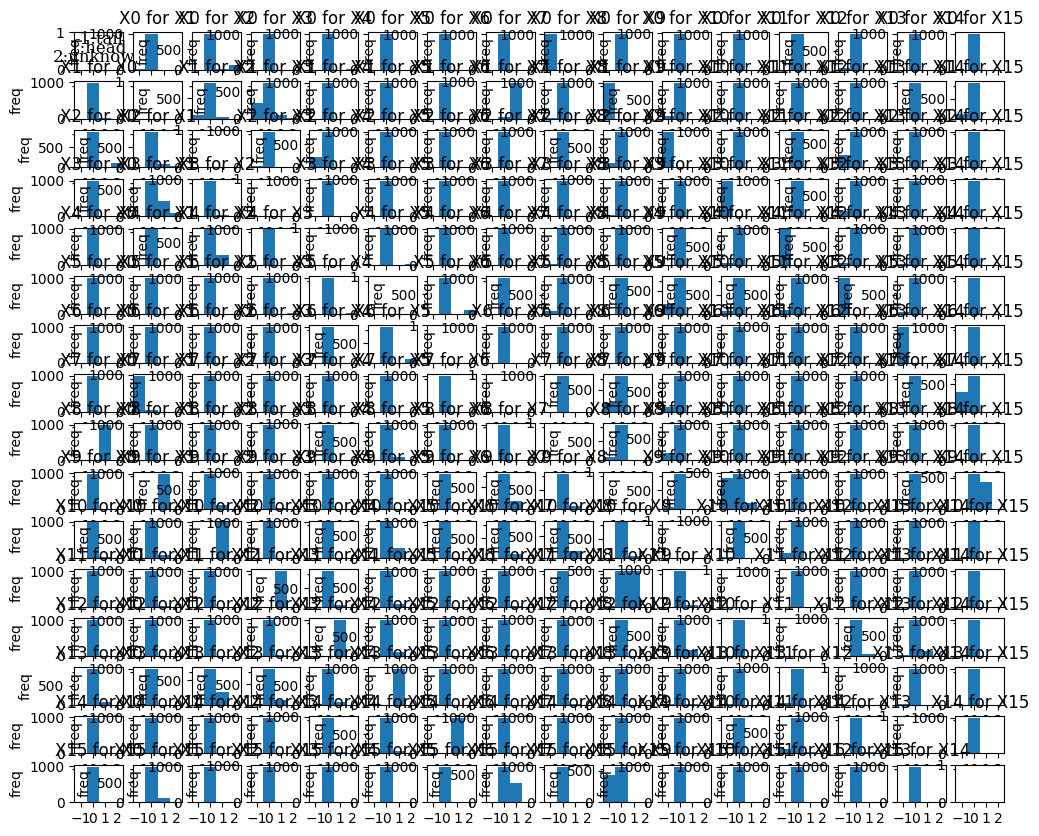

In [ ]:
 # bootstrapのsampling回数
n_bootstrapsampling = 1000
 # bootsrapの実施ループ
for i_type in range(3):
        Boot = BootstrapMixin()
        bs_results = Boot.bootstrap(X_np_array[i_type], n_bootstrapsampling, x_list_whole, i_type, background_knowledge=bk)
        boot_prob = Boot.get_probabilities(threshold = 0.1)
        if i_type == 0:
           Boot.print_probabilities('Doctor_bootstrap_fci_type1')
        elif i_type == 1:
           Boot.print_probabilities('Doctor_bootstrap_fci_type2')
        elif i_type == 2:
           Boot.print_probabilities('Doctor_bootstrap_fci_type3')

        fig, axes = plt.subplots(X_np_array[0].shape[1], X_np_array[0].shape[1], tight_layout=True, figsize=[12.0,10.0])
        #fig.subplots_adjust(wspace=0.4, hspace=0.74)
        plt.subplots_adjust(hspace=0.3)
        range_bin_width = [-1.5,-0.5,0.5,1.5,2.5]

        for axes_row in axes :
            for ax in axes_row :
                ax.set_xlim(-1.5, 2.5)
                ax.set_xticks([-1,0,1,2])

        label_a = '-1:tail'
        label_b = '1:head'
        label_c = '2:unknown'
        label_pos = [0.5,0.45]
        axes[0,0].text(x=label_pos[0], y=label_pos[1]+0.25, s=label_a, color='black', ha='center', family="serif", fontsize='12')
        axes[0,0].text(x=label_pos[0], y=label_pos[1]+0.00, s=label_b, color='black', ha='center', family="serif", fontsize='12')
        axes[0,0].text(x=label_pos[0], y=label_pos[1]-0.25, s=label_c, color='black', ha='center', family="serif", fontsize='12')

        for f1 in range (X_np_array[0].shape[1]):
            for t1 in range (X_np_array[0].shape[1]):
                if f1 != t1:
                    title = 'X' + str(f1) + ' for ' + 'X' + str(t1)
                    g_data = bs_results[:,f1,t1]
                    axes[f1,t1].hist(g_data, bins=range_bin_width)
                    axes[f1,t1].set_ylabel('freq')
                    axes[f1,t1].set_title(title)

        if i_type == 0:
            figure_title = 'Doctor_fci_type1_BSsampling_' + str(n_bootstrapsampling) + '.png'
        elif i_type == 1:
            figure_title = 'Doctor_fci_type2_BSsampling_' + str(n_bootstrapsampling) + '.png'
        elif i_type == 2:
            figure_title = 'Doctor_fci_type3_BSsampling_' + str(n_bootstrapsampling) + '.png'
        plt.savefig(figure_title)

MultiGroup RCD

In [ ]:
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

In [ ]:
X_list = [X[0], X[1], X[2]]

In [ ]:
model = lingam.MultiGroupRCD()
model.fit(X_list)

In [ ]:
ancestors_list = model.ancestors_list_

for i, ancestors in enumerate(ancestors_list):
    print(f'M{i}={ancestors}')

M0=set()
M1=set()
M2=set()
M3=set()
M4=set()
M5=set()
M6=set()
M7={14, 6}
M8=set()
M9=set()
M10=set()
M11={6, 14}
M12=set()
M13={5, 6}
M14=set()
M15=set()


In [ ]:
print(model.adjacency_matrices_[0])
make_dot(model.adjacency_matrices_[0], labels = x_list_whole)
dot = make_dot(model.adjacency_matrices_[0], labels = x_list_whole)
dot.format = 'png'
dot.render('MultigroupRCD_type1')

[[0.                nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan 0.                nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan 0.                nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan 0.                nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan        nan 0.                nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan        nan        nan 0.
         nan        nan  

'MultigroupRCD_type1.png'

In [ ]:
print(model.adjacency_matrices_[1])
make_dot(model.adjacency_matrices_[1], labels = x_list_whole)
dot = make_dot(model.adjacency_matrices_[1], labels = x_list_whole)
dot.format = 'png'
dot.render('MultigroupRCD_type2')

[[0.                nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan 0.                nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan 0.                nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan 0.                nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan        nan 0.                nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan        nan        nan 0.
         nan        nan  

'MultigroupRCD_type2.png'

In [ ]:
print(model.adjacency_matrices_[2])
make_dot(model.adjacency_matrices_[2], labels = x_list_whole)
dot = make_dot(model.adjacency_matrices_[2], labels = x_list_whole)
dot.format = 'png'
dot.render('MultigroupRCD_type3')

[[0.                nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan 0.                nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan 0.                nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan 0.                nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan        nan 0.                nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [       nan        nan        nan        nan        nan 0.
         nan        nan  

'MultigroupRCD_type3.png'

通常のRCD

In [ ]:
model = lingam.RCD()
model.fit(X[0])

In [ ]:
print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot = make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot.format = 'png'
dot.render('RCD_type1')

[[0.                nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan 0.                nan]
 [       nan 0.                nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan        nan 0.                nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan 0.                nan]
 [       nan        nan        nan 0.                nan        nan
  0.                nan        nan        nan        nan        nan
         nan        nan 0.                nan]
 [       nan        nan        nan        nan 0.                nan
         nan        nan        nan        nan        nan        nan
         nan        nan 0.                nan]
 [       nan        nan        nan        nan        nan 0.
         nan        nan  

'RCD_type1.png'

In [ ]:
model = lingam.RCD()
model.fit(X[1])

In [ ]:
print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot = make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot.format = 'png'
dot.render('RCD_type2')

[[0.                nan 0.         0.         0.                nan
  0.         0.                nan        nan 0.         0.
  0.                nan 0.         0.        ]
 [       nan 0.                nan 0.                nan        nan
  0.         0.                nan        nan        nan 0.
         nan        nan 0.         0.        ]
 [0.                nan 0.                nan        nan        nan
         nan        nan 0.                nan        nan        nan
         nan        nan 0.                nan]
 [0.         0.                nan 0.                nan 0.
         nan        nan 0.         0.                nan        nan
         nan 0.         0.                nan]
 [0.                nan        nan        nan 0.                nan
         nan        nan 0.                nan        nan        nan
         nan        nan 0.                nan]
 [       nan        nan        nan 0.                nan 0.
  0.                nan        nan        nan    

'RCD_type2.png'

In [ ]:
model = lingam.RCD()
model.fit(X[2])

In [ ]:
print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot = make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot.format = 'png'
dot.render('RCD_type3')

[[ 0.          0.                 nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan  0.          0.                 nan]
 [ 0.          0.          0.          0.          0.          0.
   0.                 nan  0.          0.97352365  0.          0.
   0.          0.          0.          0.        ]
 [        nan  0.          0.                 nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan  0.          0.                 nan]
 [        nan  0.                 nan  0.                 nan         nan
          nan         nan         nan         nan         nan         nan
          nan  0.          0.                 nan]
 [        nan  0.                 nan         nan  0.                 nan
          nan         nan         nan         nan         nan         nan
          nan  0.          0.                 nan]
 [        nan  0.    

'RCD_type3.png'

CAM-UV

In [ ]:
model = lingam.CAMUV()
model.fit(X[0])

In [ ]:
print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot = make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot.format = 'png'
dot.render('CAM-UV_type1')

[[ 0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan  0. nan nan nan nan  1. nan nan nan nan nan nan nan nan nan]
 [nan nan  0. nan nan nan  1. nan nan nan nan nan nan nan nan nan]
 [nan nan nan  0. nan nan  1. nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan  0. nan  0. nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan]
 [nan  0.  0.  0.  0. nan  0.  0. nan  0.  0.  0.  0. nan  1.  0.]
 [nan nan nan nan nan nan  0.  0. nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan  1. nan nan  0. nan nan nan nan nan nan]
 [nan nan nan nan nan nan  1. nan nan nan  0. nan nan nan nan nan]
 [nan nan nan nan nan nan  1. nan nan nan nan  0. nan nan nan nan]
 [nan nan nan nan nan nan  0. nan nan nan nan nan  0. nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan  0. nan nan]
 [nan nan nan nan nan nan  0. nan nan nan nan nan nan nan  0. 

'CAM-UV_type1.png'

In [ ]:
model = lingam.CAMUV()
model.fit(X[1])

In [ ]:
print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot = make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot.format = 'png'
dot.render('CAM-UV_type2')

[[ 0. nan nan nan nan nan nan nan nan nan nan nan nan  0.  0. nan]
 [nan  0. nan  1.  0.  0.  0.  0. nan nan nan  0.  0.  0.  0.  0.]
 [nan nan  0. nan nan nan nan nan nan nan nan nan nan  0.  0. nan]
 [nan  0. nan  0. nan  0.  0. nan nan nan nan nan nan  0.  0. nan]
 [nan  0. nan nan  0.  0.  0.  0. nan nan nan nan nan  0.  0. nan]
 [nan  1. nan  0.  1.  0.  0.  0. nan nan nan  0.  0.  0.  0.  0.]
 [nan  0. nan  0.  0.  1.  0.  0.  1. nan nan nan  0.  0.  0.  0.]
 [nan  0. nan nan  0.  0.  0.  0. nan nan nan nan nan  0.  0. nan]
 [nan nan nan nan nan nan  0. nan  0. nan nan nan nan  0.  0. nan]
 [nan nan nan nan nan nan nan nan nan  0. nan nan nan  0.  0. nan]
 [nan nan nan nan nan nan nan nan nan nan  0. nan nan  0.  0. nan]
 [nan  0. nan nan nan  0. nan nan nan nan nan  0. nan  0.  0. nan]
 [nan  0. nan nan nan  0.  0. nan nan nan nan nan  0.  0.  0. nan]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. 

'CAM-UV_type2.png'

In [ ]:
model = lingam.CAMUV()
model.fit(X[2])

In [ ]:
print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot = make_dot(model.adjacency_matrix_, labels = x_list_whole)
dot.format = 'png'
dot.render('CAM-UV_type3')

[[ 0.  0.  0. nan  0. nan  0. nan  0.  0.  0.  0.  0.  0. nan nan]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. nan]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan  0.  0.  0. nan  0.]
 [nan  0.  0.  0.  0. nan  0.  0.  0.  1.  0. nan  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  0. nan nan  0.  0.  0. nan  0.  0. nan]
 [nan  0.  0. nan  0.  0.  0. nan  0.  0.  0. nan  0.  0. nan nan]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [nan  0.  0.  0. nan nan  0.  0.  0.  0.  0.  0. nan  0. nan nan]
 [ 1.  0.  0.  0. nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. nan  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0. nan  0. nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan  1.  0. nan  0.  0.  1.  0.  0.  0.  0. nan]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [nan  0. nan  0.  0. nan  0. nan  0.  1.  0.  0.  0.  0.  0. 

'CAM-UV_type3.png'

BottomUpParceLiNGAM

In [ ]:
model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)
model.fit(X[0])
print(model.causal_order_)
print(model.adjacency_matrix_)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
[[ 0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan  0. nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan  0. nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan  0. nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan  0. nan nan]
 [nan

In [ ]:
model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)
model.fit(X[1])
print(model.causal_order_)
print(model.adjacency_matrix_)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
[[ 0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan  0. nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan  0. nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan  0. nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan  0. nan nan]
 [nan

In [ ]:
model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)
model.fit(X[2])
print(model.causal_order_)
print(model.adjacency_matrix_)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
[[ 0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan  0. nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan  0. nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan  0. nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan  0. nan nan]
 [nan

PC

In [ ]:
for i_type in range(3):
        cg = pc(X_np_array[i_type], independence_test_method="fisherz", background_knowledge=bk)

        # visualization
        pdy = GraphUtils.to_pydot(cg.G, labels = x_list_whole)
        if i_type == 0:
            pdy.write_png('Doctor_pc_type1.png')
        elif i_type == 1:
            pdy.write_png('Doctor_pc_type2.png')
        elif i_type == 2:
            pdy.write_png('Doctor_pc_type3.png')

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Exact Search

In [ ]:
super_structure = -np.ones((X[0].shape[1],X[0].shape[1])).astype(int)
super_structure_contemporary = np.array(
    [[0, 0, 1, 1, 1, 1, 1, 1],
     [1, 0, 1, 1, 1, 1, 1, 1],
     [1, 1, 0, 0, 0, 1, 1, 1],
     [1, 1, 1, 0, 1, 1, 1, 1],
     [1, 1, 1, 1, 0, 1, 1, 1],
     [1, 1, 1, 1, 1, 0, 1, 1],
     [1, 1, 1, 1, 1, 1, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 0]]
    )

for t in range (tau_max+1):
        super_structure[t*n_features:(t+1)*n_features,t*n_features:(t+1)*n_features] = super_structure_contemporary
        for t_L in range(t+1,tau_max+1):
            super_structure[t*n_features:(t+1)*n_features,t_L*n_features:(t_L+1)*n_features] = 0

In [ ]:
#prior_knowledgeを入れる関数を少しだけ改変して、ラベルも入れて、ビジュアル化できるようにする。
def make_prior_knowledge_graph(prior_knowledge_matrix,labels):
    d = graphviz.Digraph(engine='dot')

    if labels == None:
      labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]

    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

In [ ]:
dag_est_type1, search_stats_type1 = bic_exact_search(X_np_array[0], super_graph=super_structure, verbose=False)
dag_est_type1

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,

In [ ]:
make_dot(dag_est_type1, labels = x_list_whole)
dot = make_prior_knowledge_graph(dag_est_type1, labels = x_list_whole)
dot.format = 'png'
dot.render('BIC_ES_type1')

'BIC_ES_type1.png'

In [ ]:
dag_est_type2, search_stats_type2 = bic_exact_search(X_np_array[1], super_graph=super_structure, verbose=False)
dag_est_type2

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,

In [ ]:
make_dot(dag_est_type2, labels = x_list_whole)
dot = make_prior_knowledge_graph(dag_est_type2, labels = x_list_whole)
dot.format = 'png'
dot.render('BIC_ES_type2')

'BIC_ES_type2.png'

In [ ]:
dag_est_type3, search_stats_type3 = bic_exact_search(X_np_array[2], super_graph=super_structure, verbose=False)
dag_est_type3

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,

In [ ]:
make_dot(dag_est_type3, labels = x_list_whole)
dot = make_prior_knowledge_graph(dag_est_type3, labels = x_list_whole)
dot.format = 'png'
dot.render('BIC_ES_type3')

'BIC_ES_type3.png'